<b>Hyperparameters</b>: 
<br><b>win_tol</b>: window tolerance within which if a method detected cp, count that as true changepoint detected
<br>win_tol=2
<br>For BOCD: <b>run_length_threshold</b> - the change in run_length that constitutes a changepoint, for example if run_length_threshold is set to 4, then if run length drops by 4 or more, then that constitutes a changepoint
<br>For gradient based: <b>gradient_threshold</b>: the threshold above which a change in gradient constitutes a changepoint.
<br>For MC_dropout: <b>mc_dropout_threshold</b>: the threshold above which a change in variance in any of the output dimensions constitutes a changepoint
<br>
<br> <b>If TP=FP=0, Precision=1 rather than 0 and if TP=FN=0, then Recall=1 rather than 0 
<br> zero division is taken as 1 and not 0 for Precision and Recall</b>
<br> example: true_cps = [3, 31, 250, 273], pred_cps = [30, 31, 249, 250, 272, 300]
<br> TP = 3, FP = 1, FN = 1, TN = 317-5 = 312
<br> true changepoint 3 could not be detected but the rest were detected within the window tolerance
<br> false changepoint 300 was detected
<br>
<br>Precision = TP/(TP+FP)
<br>Recall or A_cp = TP/(TP+FN)
<br>A_cp = Accuracy for detecting changepoints (minority class)
<br>Accuracy = (TP+TN)/(TP+TN+FP+FN)
<br>A_major or A_no_cp = TN/(TN+FP)
<br>A_major or A_no_cp = Accuracy for detecting points that are not changepoints (majority class)
<br>Balanced_Accuracy = 1/2*(A_cp+A_major)

In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from   matplotlib.colors import LogNorm
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score, auc
from sklearn import metrics

In [2]:
root_dir = "/home/users/richras/Ge2Net_Repo"
os.chdir(root_dir)

In [3]:
!./ini.sh

/bin/sh: ./ini.sh: Permission denied


In [4]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [5]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows
from src.utils.modelUtil import Params, load_model
from src.utils.decorators import timer
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred
import inference

# load the model and use valid data to choose hyperpparams for the different cp methods

In [6]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_4_geo')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_4_geo')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_Q_exp_id_3_data_id_4_geo/') 
dataset_type='test'

In [7]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
json_path = osp.join(config['models.dir'], 'params.yaml')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
params.evalCp=True
params.evalBalancedGcd=True
params.evalExtraMainLosses=True
params.cp_pos_weight=10.0
params.pretrained=False
params.valid_gens=[0,2,4,8]
results, valid_dataset, _, modelStats=inference.main(config, params)

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 0


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: snps data: (540, 317410)
INFO: __init__:src.main.dataset: y_labels data :(540, 317410)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0927 secs
Finished 'mapping_func' in 0.3467 secs
Finished 'pop_mapping' in 0.1350 secs
Finished 'pop_mapping' in 0.1295 secs
Finished 'transform_data' in 33.5513 secs
Finished '__init__' in 47.8268 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
device in load model:None
Finished 'load_model' in 0.5109 secs
best val loss metrics : {'loss_main': 866.6805836590546, 'loss_aux': 2160.2513772460106, 'l1_loss': 0.20087590047931303, 'mse': 0.045047710068923504, 'smooth_l1': 0.022466416130238673, 'weighted_loss': 0.20087590047931303}
at epoch : 227
train loss metrics: {'loss_main': 260.368462953392, 'loss_aux': 1561.6972164885574, 'l1_loss': 0.05821169218555197, 'mse': 0.005354038258400175, 'smooth_l1': 0.0026711223615385584, 'weighted_loss': 0.05821169218555197}
best val cp metrics : {'loss_cp':

In [8]:
results.t_out.coord_main=results.t_out.coord_main.mean(0)

In [9]:
results.t_out.coord_main.shape

(2940, 317, 3)

In [10]:
results.t_accr, results.t_cp_accr

({'l1_loss': 0.20102627919020527,
  'loss_aux': 2265.463070022962,
  'loss_main': 1082.524461898324,
  'mse': 0.03933779895503894,
  'smooth_l1': 0.01964077319287213,
  'weighted_loss': 0.20102627919020527},
 {'loss_cp': 0.6175682732428539,
  'prMetrics': OrderedDict([('Precision', array(0.03046161)),
               ('Recall', array(0.90630151)),
               ('Accuracy', array(0.75509453)),
               ('A_major', array(0.753804)),
               ('BalancedAccuracy', 0.8300527545293488)])})

In [11]:
@timer
def prMetricsByThresh(method_name, cp_pred_raw, cp_target, steps, minThresh, maxThresh, win_tol=2, byWindows=False):
    increment = (maxThresh - minThresh)/steps
    df=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
    for thresh in np.arange(minThresh, maxThresh + increment, increment):
        prMetrics, cp_pred = reportChangePointMetrics(method_name, cp_pred_raw, cp_target, thresh, win_tol)
        if byWindows: 
            prMetrics={}
            prMetrics['Precision']=precision_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Recall']=recall_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['BalancedAccuracy']=balanced_accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Accuracy']=accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['A_major']=(2*prMetrics['BalancedAccuracy'])-prMetrics['Recall']
        prMetrics['thresh']=thresh
        prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
        df=df.append(prMetrics, ignore_index=True)
    return df

# neural network, choose the threshold for logits

In [12]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        torch.tensor(valid_dataset.data['cps']).unsqueeze(2).float(), 20, 0, 0.85)
df_nn.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 33.7218 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.00874773320911042,1.0,0.04105452906714736,0.032870068272349215,0.516435,0.000000,0.017344
1,0.009827966959287341,0.99987320907823,0.14749350844438722,0.14021857107455635,0.570046,0.042500,0.019465
2,0.011107211195525412,0.99505515405097,0.25024249447413033,0.24388562623026036,0.619470,0.085000,0.021969
3,0.012283194921162505,0.9896031444148599,0.3264898388377433,0.32083026275493914,0.655217,0.127500,0.024265
4,0.01324903165065401,0.9849118803093698,0.37910899375523077,0.3739385538035674,0.679425,0.170000,0.026146
5,0.020099767987604746,0.9589197413465196,0.6040322753707161,0.6010033622157077,0.779962,0.212500,0.039374
6,0.020838115995342264,0.9552428046151895,0.6197686645636172,0.61690544133545,0.786074,0.255000,0.040786
7,0.02157811744665178,0.9508051223532396,0.6347378699113715,0.6320402816599628,0.791423,0.297500,0.042199
8,0.022302263732121543,0.9452263217953595,0.6488680014592588,0.6463386260906641,0.795782,0.340000,0.043576
9,0.02308515469946681,0.9409154304551794,0.6625388956844568,0.6601629922529443,0.800539,0.382500,0.045065


In [13]:
nnThresh=0.85

# gradient method, choose the threshold for gradient difference in predictions

In [14]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        torch.tensor(valid_dataset.data['cps']).unsqueeze(2).float(), 20, 0,1)
df_grad.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 5.8495 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.008776107445281464,1.0,0.044182278589669305,0.03602451268432939,0.518012,0.000000,0.017400
1,0.2521481087784569,0.7218207176366173,0.9795285306551643,0.9817280295381525,0.851774,0.050000,0.373740
2,0.489152269987947,0.6174717890199062,0.9913056074164681,0.9944962249470561,0.805984,0.100000,0.545872
3,0.6640502354788069,0.5363255990871053,0.9937799094401167,0.9976842157661621,0.767005,0.150000,0.593393
4,0.7680455888560574,0.46139216432103464,0.9942627524195798,0.9988107257602861,0.730101,0.200000,0.576475
5,0.8385471898197243,0.401039685558514,0.9942777742011631,0.999340975421305,0.700190,0.250000,0.542585
6,0.8849413298565841,0.34423735260555344,0.9940717611965922,0.9996180038156333,0.671928,0.300000,0.495664
7,0.9107704402515723,0.29377456574109295,0.9937799094401167,0.9997543537284668,0.646764,0.350000,0.444253
8,0.9311320754716981,0.2502852795739825,0.9934987875276293,0.9998420072438596,0.625064,0.400000,0.394524
9,0.9453213077790305,0.21262837580829214,0.9932326873967252,0.9998950322099616,0.606262,0.450000,0.347169


In [15]:
gradThresh=0.1

# mc dropout variance, choose the threshold for difference in variance

In [16]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        torch.tensor(valid_dataset.data['cps']).unsqueeze(2).float(), 20, 0,0.5)
df_var.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 5.2103 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.008776107445281464,1.0,0.044182278589669305,0.03602451268432939,0.518012,0.000000,0.017400
1,0.3958310233950549,0.45264359071890453,0.9895212343612524,0.994103407341036,0.723373,0.025000,0.422335
2,0.5409377186843947,0.2940281475846329,0.9919139895705916,0.9978703442186013,0.645949,0.050000,0.380976
3,0.6163522012578616,0.21123367566882212,0.9922122792334599,0.9988778185745374,0.605056,0.075000,0.314636
4,0.6509783183500794,0.15607962469887157,0.9921500461383291,0.9992857861708724,0.577683,0.100000,0.251790
5,0.6839038601602331,0.11905667554203118,0.992079229168008,0.9995303503002403,0.559294,0.125000,0.202808
6,0.7014925373134329,0.0893875998478509,0.9919719307281272,0.9996753573503966,0.544531,0.150000,0.158570
7,0.7157894736842105,0.06897426144288069,0.9918893109294191,0.9997662572922855,0.534370,0.175000,0.125824
8,0.7373913043478261,0.053759350830480536,0.9918302967874847,0.9998365965330329,0.526798,0.200000,0.100213
9,0.7585421412300684,0.04222137694941042,0.9917809395051396,0.9998852929304735,0.521053,0.225000,0.079990


In [17]:
varThresh=0.025

# BOCD, Compute the run lengths and changepoints by using a multivariate Gaussian (with independent three dimensions of predictions) to model the prediction sequence

In [18]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
posterior, _, predictive, e_mean = model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 198.1846 secs


In [19]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        torch.tensor(valid_dataset.data['cps']).unsqueeze(2).float(), 20,1,10)
df_bocd.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 13.7158 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.7989255564082886,0.39596804868771396,0.9940449365866221,0.999149436258039,0.697559,1.000000,0.529502
1,0.7989255564082886,0.39596804868771396,0.9940449365866221,0.999149436258039,0.697559,1.450000,0.529502
2,0.7989255564082886,0.39596804868771396,0.9940449365866221,0.999149436258039,0.697559,1.900000,0.529502
3,0.7200065919578115,0.5539495372131356,0.9944022403914247,0.9981614404610791,0.776055,2.350000,0.626155
4,0.7200065919578115,0.5539495372131356,0.9944022403914247,0.9981614404610791,0.776055,2.800000,0.626155
5,0.6678925035360679,0.5987067325979459,0.9940846370093779,0.9974591301957704,0.798083,3.250000,0.631410
6,0.6678925035360679,0.5987067325979459,0.9940846370093779,0.9974591301957704,0.798083,3.700000,0.631410
7,0.6319833311629118,0.6153163433498161,0.9937123114229919,0.9969418662407356,0.806129,4.150000,0.623538
8,0.6319833311629118,0.6153163433498161,0.9937123114229919,0.9969418662407356,0.806129,4.600000,0.623538
9,0.6025672371638142,0.6249524534043363,0.9933378398678083,0.996481955820464,0.810717,5.050000,0.613556


In [20]:
bocdThresh=4.0

# Summary Table with chosen thresholds

In [21]:
pd.options.display.float_format='{:,.4f}'.format
df_summary=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
cpThresh=[nnThresh, gradThresh, varThresh, bocdThresh]
cp_target=valid_dataset.data['cps']
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(), model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, cp_target, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary=df_summary.append(prMetrics, ignore_index=True)
df_summary

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.16694335613254532,0.6375047546595664,0.9700111590377476,0.9728490530714982,0.8052,0.8500,0.2646,neural_network
1,0.489152269987947,0.6174717890199062,0.9913056074164681,0.9944962249470561,0.8060,0.1000,0.5459,gradient
2,0.3958310233950549,0.45264359071890453,0.9895212343612524,0.994103407341036,0.7234,0.0250,0.4223,mc_dropout
3,0.6319833311629118,0.6153163433498161,0.9937123114229919,0.9969418662407356,0.8061,4.0000,0.6235,BOCD


plot of Precision/Recall

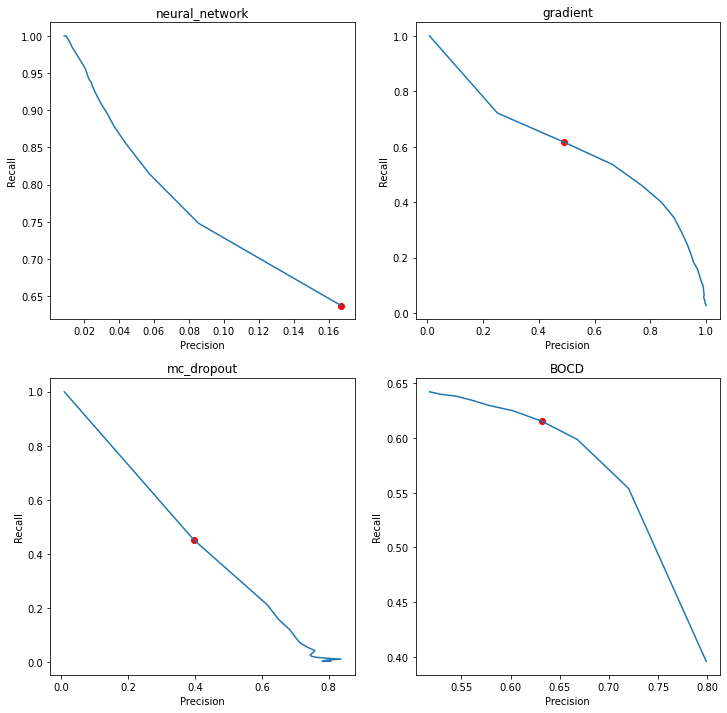

In [22]:
fig, ax = plt.subplots(2,2,figsize=[12,12])

for (row,col), df, name in zip(itertools.product([0,1],[0,1]),[df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    ax[row,col].plot(df['Precision'], df['Recall'])
    ax[row,col].set_xlabel('Precision')
    ax[row,col].set_ylabel('Recall')
    ax[row,col].set_title(name)
    df_row=df_summary[df_summary.Name==name]
    ax[row,col].scatter(df_row['Precision'], df_row['Recall'], color='r')
plt.show()

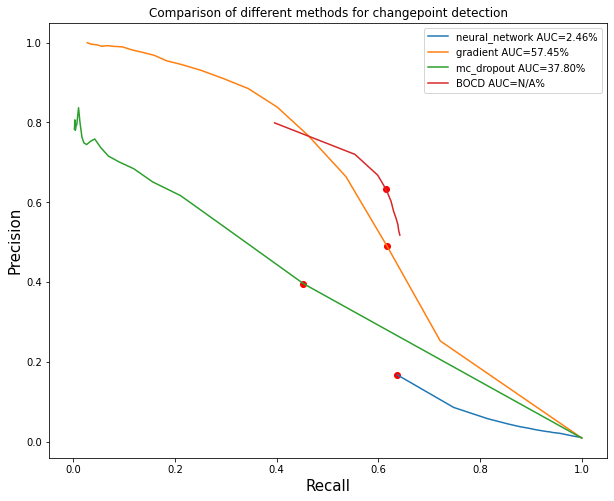

In [23]:
fig, ax = plt.subplots(figsize=[10,8])

for df, name in zip([df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    aucScore = "N/A"
    if name!="BOCD":
        aucScore = format(auc(df['Recall'], df['Precision'])*100, ".2f")
    plt.plot(df['Recall'], df['Precision'], label=str(name) + " AUC="+ str(aucScore)+"%")
    plt.ylabel('Precision', fontsize=15)
    plt.xlabel('Recall', fontsize=15)
    plt.title("Comparison of different methods for changepoint detection")
    df_row=df_summary[df_summary.Name==name]
    plt.scatter(df_row['Recall'], df_row['Precision'], color='r')
    plt.legend(loc="best")
plt.show()

# Qualitative by looking at anecdotes/samples

In [156]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
cp_target=valid_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(), model_cpd.cp]
pred_cps = {}
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    _, pred_cps[name]= reportChangePointMetrics(name, pred_raw, cp_target, thresh)

true_cps=cp_target
pred_cps={k:v.detach().cpu().numpy() for k,v in pred_cps.items()}

In [157]:
# def plot_changepoints(true_cps, pred_cps, y_pred, bocp_rl, y_var, popNames):
#     fig, ax = plt.subplots(8,1,figsize=[18,30])
#     ax[0].plot(y_pred)
#     ax[0].text(0, np.max(y_pred)-0.5, s=popNames[0], size=10)
#     for i in np.nonzero(true_cps)[0]:
#         ax[0].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
#         ax[0].text(i, np.max(y_pred)-0.5, s=popNames[i+1], size=10)
#     ax[1].plot(pred_cps[cpMethod.gradient.name])
#     ax[2].plot(y_var)
#     ax[3].plot(pred_cps[cpMethod.mc_dropout.name])
#     ax[4].plot(pred_cps[cpMethod.neural_network.name])
#     ax[5].plot(np.arange(T+1), bocp_rl)
#     ax[6].plot(pred_cps[cpMethod.BOCD.name])
#     ax[7].plot(true_cps)
    
#     ax[0].set_title("n_vectors")
#     ax[1].set_title("Simple gradient(post_process)")
#     ax[2].set_title("Mc dropout variance")
#     ax[3].set_title("Mc dropout")
#     ax[4].set_title("Neural Network predicted cp")
#     ax[5].set_title("BOCD (post process) run_length")
#     ax[6].set_title("BOCD (post process) cp")
#     ax[7].set_title("True Cps")
#     plt.show()

In [158]:
def plot_changepoints(true_cps, pred_cps, y_pred, bocp_rl, y_var, popNames):
    fig, ax = plt.subplots(7,1,figsize=[18,30])
    ax[0].plot(y_pred)
    ax[0].text(0, np.max(y_pred)-0.5, s=popNames[0], size=10)
    for i in np.nonzero(true_cps)[0]:
        ax[0].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
        ax[0].text(i, np.max(y_pred)-0.5, s=popNames[i+1], size=10)
    ax[1].plot(pred_cps[cpMethod.gradient.name])
    ax[1].text(0, np.max(y_pred)-0.5, s=popNames[0], size=10)
    for i in np.nonzero(true_cps)[0]:
        ax[1].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
    ax[2].plot(y_var)
    ax[2].text(0, np.max(y_pred)-0.5, s=popNames[0], size=10)
    for i in np.nonzero(true_cps)[0]:
        ax[2].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
    ax[3].plot(pred_cps[cpMethod.mc_dropout.name])
    ax[3].text(0, np.max(y_pred)-0.5, s=popNames[0], size=10)
    for i in np.nonzero(true_cps)[0]:
        ax[3].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
    ax[4].plot(pred_cps[cpMethod.mc_dropout.name])
    ax[4].text(0, np.max(y_pred)-0.5, s=popNames[0], size=10)
    for i in np.nonzero(true_cps)[0]:
        ax[4].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
    ax[5].plot(np.arange(T+1), bocp_rl)
    ax[5].text(0, np.max(y_pred)-0.5, s=popNames[0], size=10)
    for i in np.nonzero(true_cps)[0]:
        ax[5].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
    ax[6].plot(pred_cps[cpMethod.BOCD.name])
    ax[6].text(0, np.max(y_pred)-0.5, s=popNames[0], size=10)
    for i in np.nonzero(true_cps)[0]:
        ax[6].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
    
    
    ax[0].set_title("n_vectors")
    ax[1].set_title("Simple gradient(post_process)")
    ax[2].set_title("Mc dropout variance")
    ax[3].set_title("Mc dropout")
    ax[4].set_title("Neural Network predicted cp")
    ax[5].set_title("BOCD (post process) run_length")
    ax[6].set_title("BOCD (post process) cp")
    plt.show()

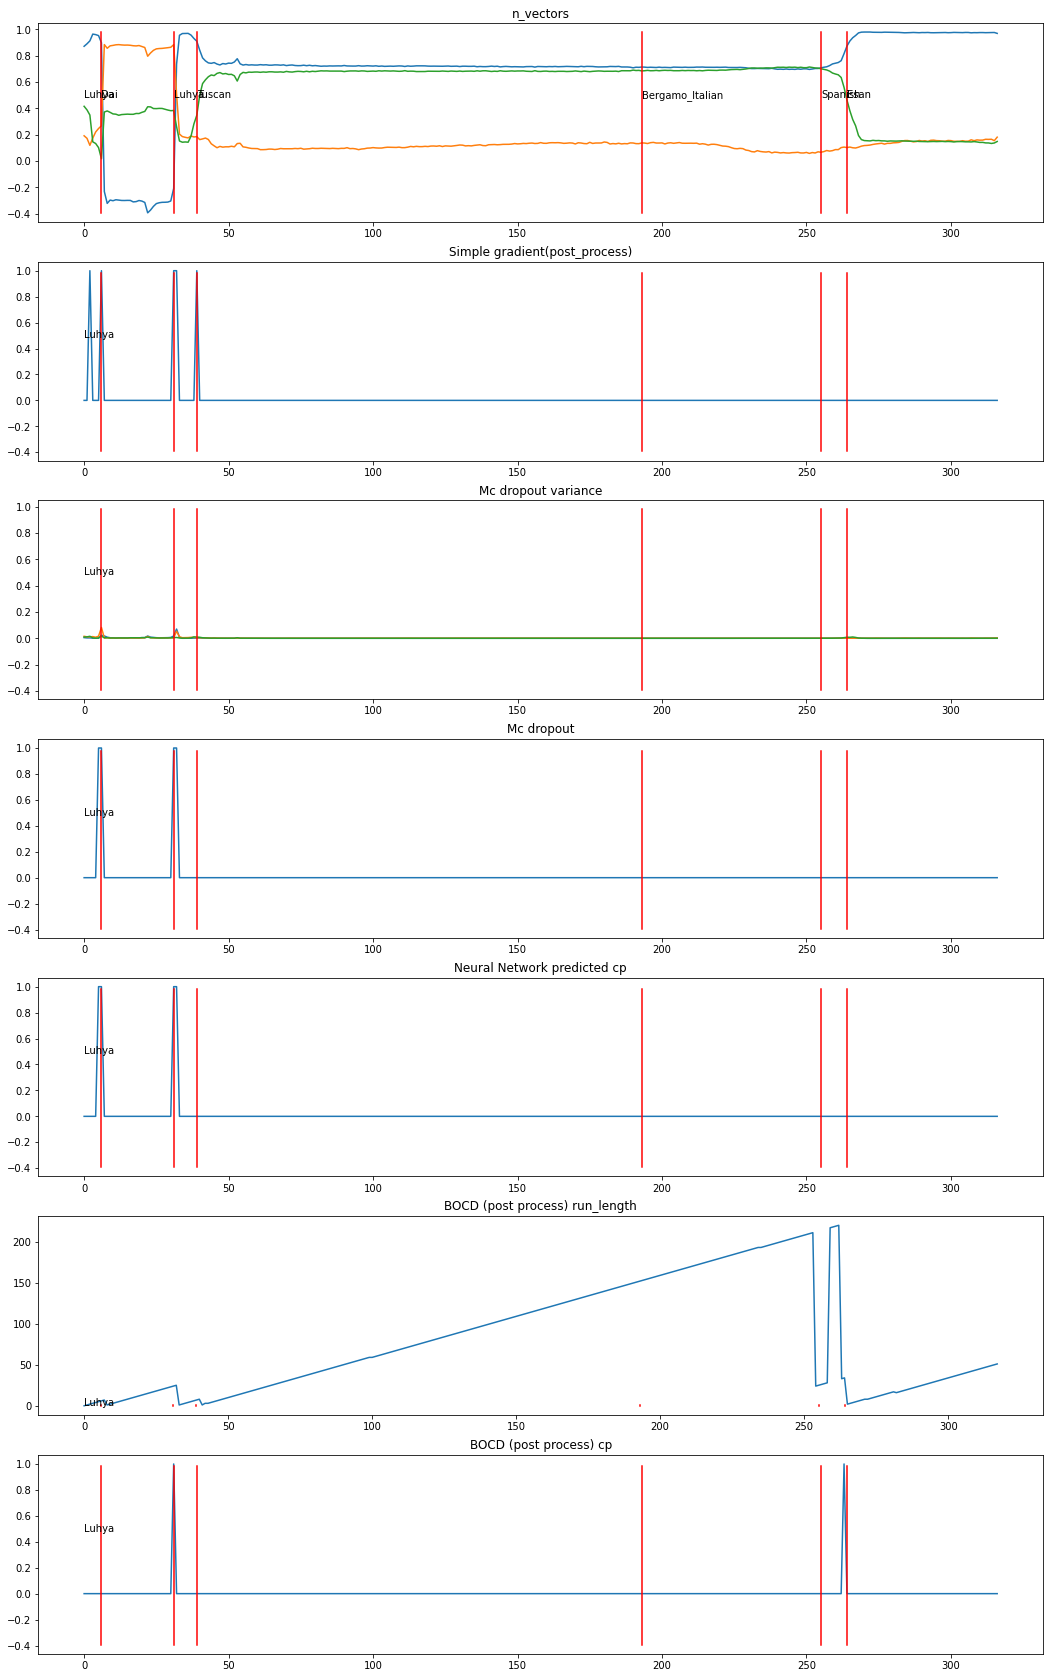

In [159]:
index = 2620
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

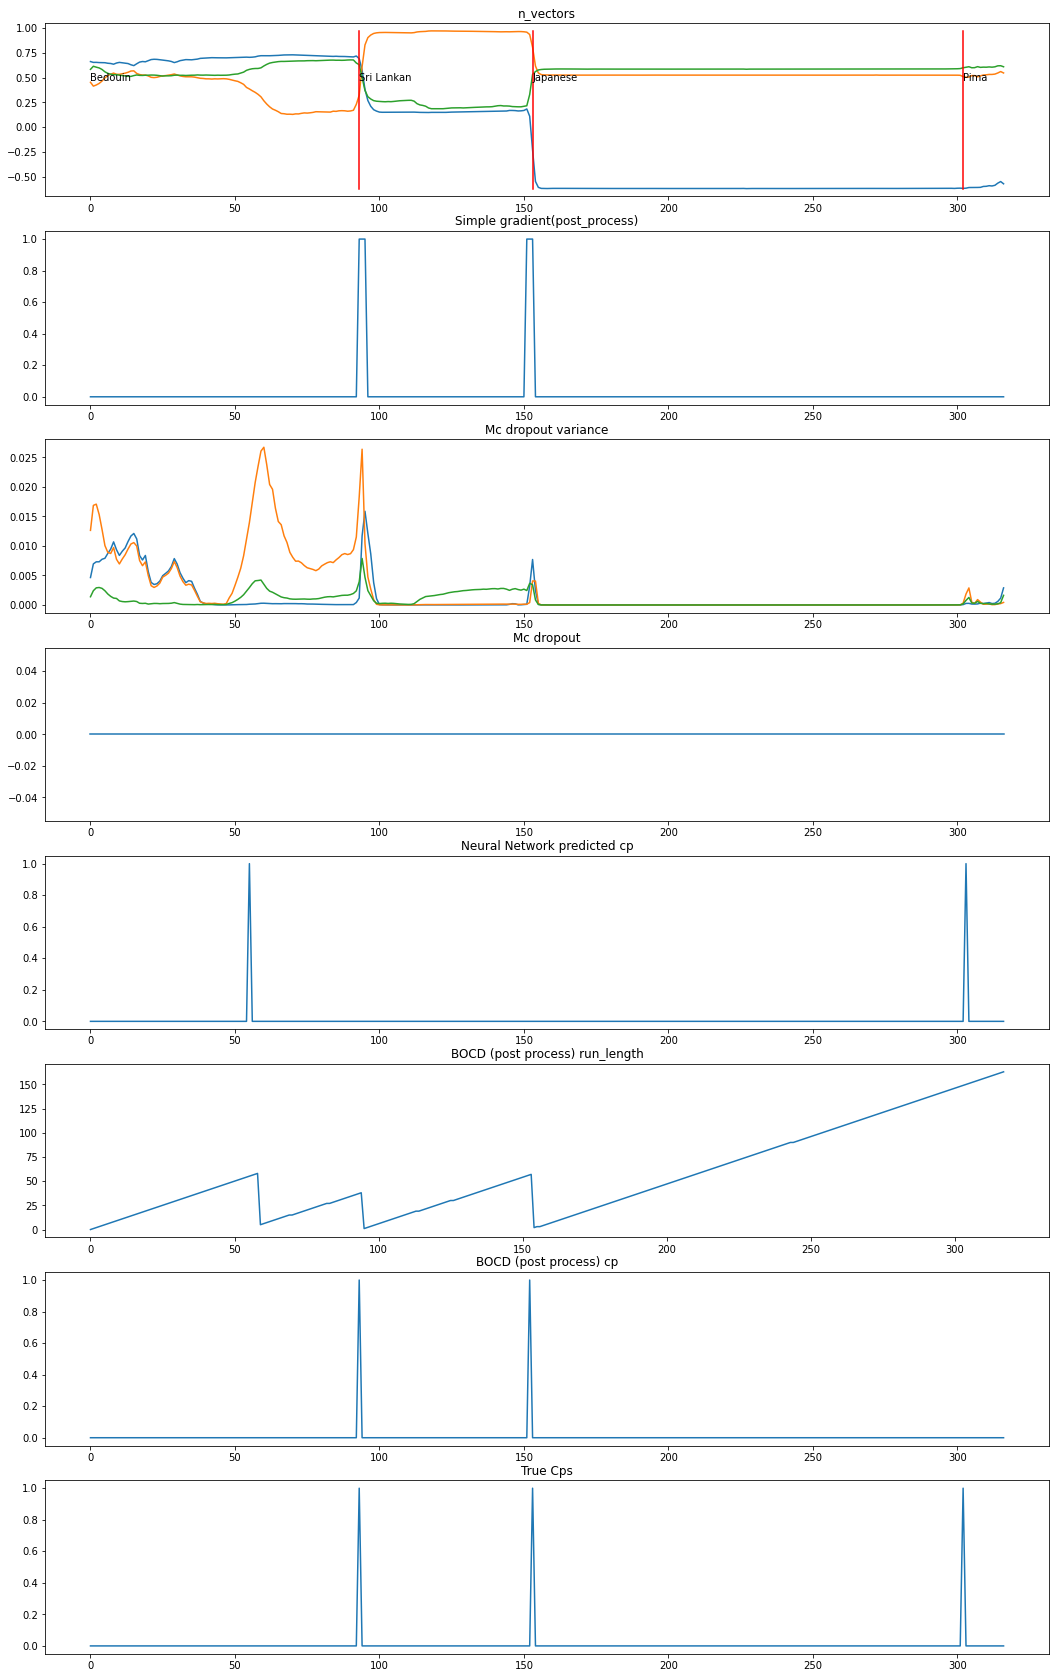

In [27]:
index = 2620
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

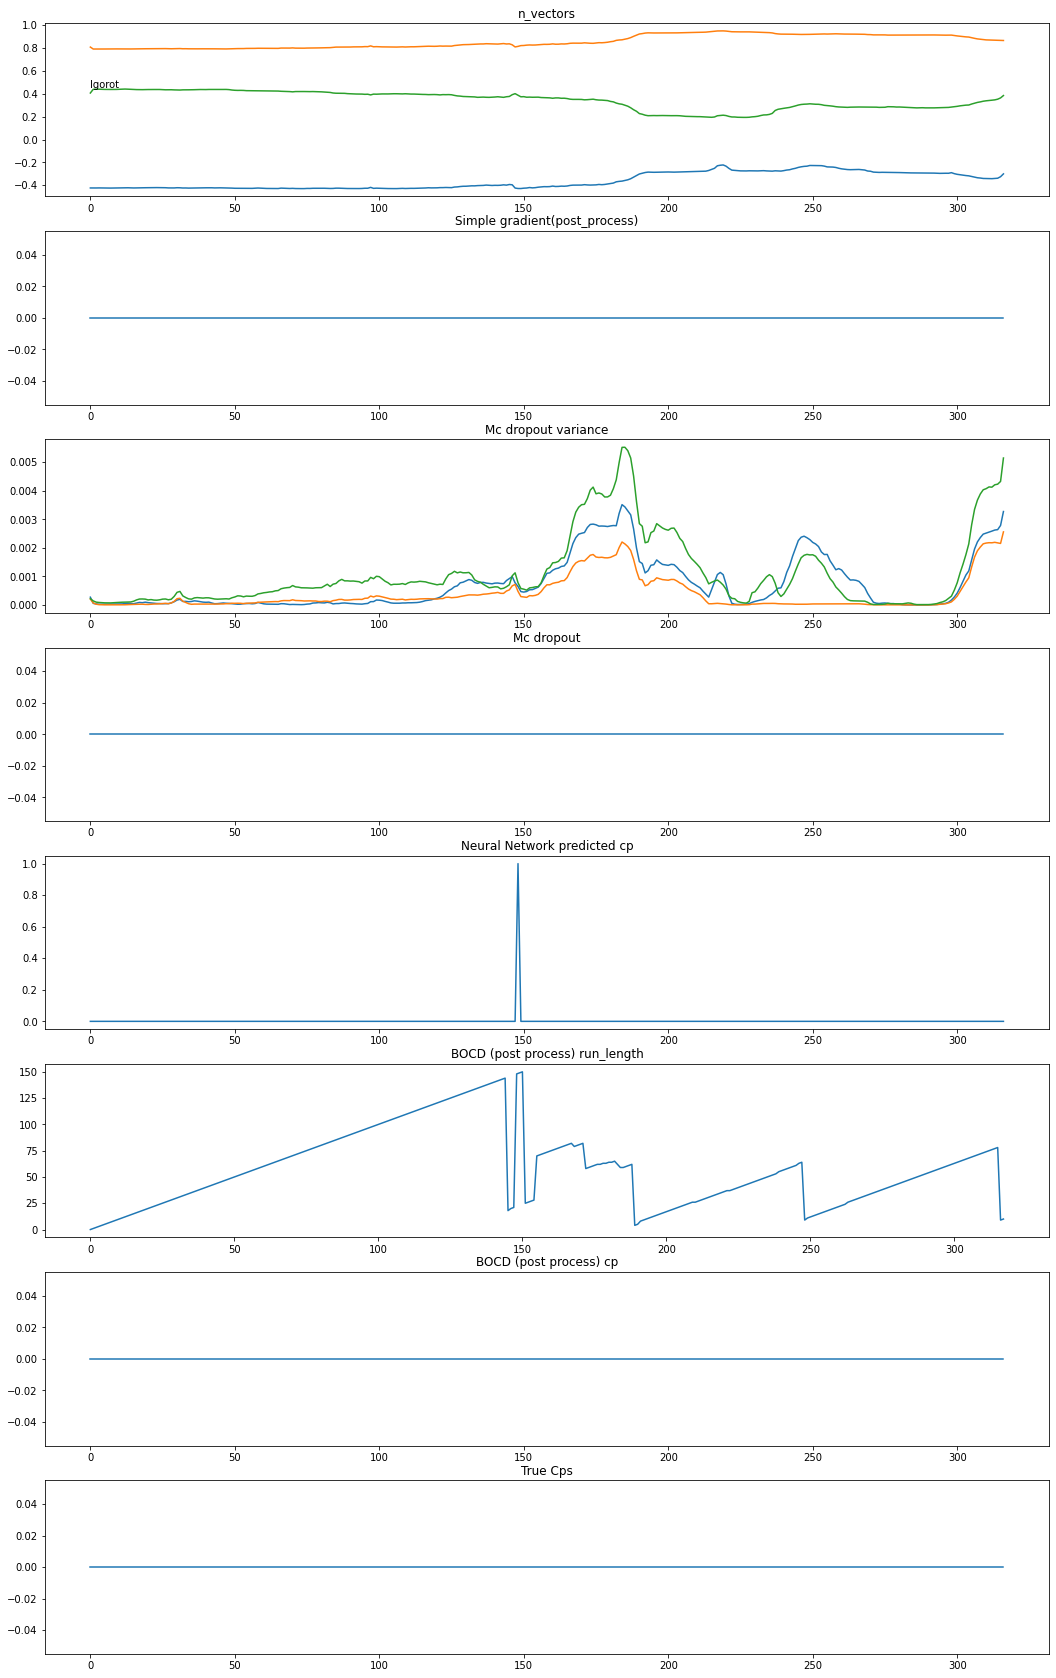

In [28]:
index = 1200
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

# evaluate on a subset of samples that have at least 1 changepoint 


In [29]:
subset_idx=np.unique(np.nonzero(valid_dataset.data['cps'])[0])

In [30]:
df_summary_subset=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
subsetSamples_trueCps=valid_dataset.data['cps'][..., np.newaxis][subset_idx,:]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
             torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), 
             torch.tensor(results.t_out.y_var[subset_idx,:]).float(),\
             model_cpd.cp[subset_idx,:]]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, subsetSamples_trueCps, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary_subset=df_summary_subset.append(prMetrics, ignore_index=True)
df_summary_subset

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.3217665615141956,0.3717481462862888,0.9836989485720256,0.9908470480812565,0.6813,0.4550,0.3450,neural_network
1,0.5163054285146153,0.65263290184743,0.9889299696150955,0.9928582019110366,0.8227,0.1000,0.5765,gradient
2,0.4788598574821853,0.2533618197813246,0.9881957403091889,0.9967792178813596,0.6251,0.0250,0.3314,mc_dropout
3,0.6290302655960469,0.6399396757571949,0.9914852617251777,0.995591609524942,0.8178,3.0000,0.6344,BOCD


# compute metrics by placing win_tol=0

In [31]:
df_zero_tol=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
trueCps=valid_dataset.data['cps'][..., np.newaxis]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), \
             torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(),\
             model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, trueCps, thresh, win_tol=0)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_zero_tol=df_zero_tol.append(prMetrics, ignore_index=True)
df_zero_tol

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.10082842003134562,0.1697876083951238,0.9838779655157512,0.9895152089517558,0.5797,0.4550,0.1265,neural_network
1,0.23383454651718824,0.5530979012190524,0.9844639384641978,0.9874509722015538,0.7703,0.1000,0.3287,gradient
2,0.2086969383227333,0.17732813874575845,0.9897186811287325,0.9953441540414919,0.5863,0.0250,0.1917,mc_dropout
3,0.22713352388730093,0.27962800050270203,0.9885026576206732,0.9934113252800252,0.6365,3.0000,0.2507,BOCD


# evaluate to make sure matches with scikit learn (subset with samples that have cp, and win_tol=0 for evaluation

In [32]:
df_summary_subset=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
subsetSamples_trueCps=valid_dataset.data['cps'][..., np.newaxis][subset_idx,:]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
             torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), 
             torch.tensor(results.t_out.y_var[subset_idx,:]).float(),\
             model_cpd.cp[subset_idx,:]]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, subsetSamples_trueCps, thresh, win_tol=0)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary_subset=df_summary_subset.append(prMetrics, ignore_index=True)
df_summary_subset

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.12546433878157504,0.1697876083951238,0.9767498889949765,0.9861758864123805,0.5780,0.4550,0.1443,neural_network
1,0.2619019281123542,0.5530979012190524,0.9768427559427592,0.9817924518607577,0.7674,0.1000,0.3555,gradient
2,0.24041574373828592,0.17732813874575845,0.9840326891656195,0.9934556760779858,0.5854,0.0250,0.2041,mc_dropout
3,0.27297264139369404,0.27962800050270203,0.9830837050429655,0.9913006586895792,0.6355,3.0000,0.2763,BOCD


# evaluate by Windows

In [33]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        valid_dataset.data['cps'][..., np.newaxis], 20, 0.4, 0.5, byWindows=True)
df_nn.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 88.8001 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.025221,0.429559,0.881903,0.885035,0.657297,0.400000,0.047644
1,0.025098,0.425789,0.882313,0.885474,0.655631,0.405000,0.047403
2,0.024972,0.421893,0.882741,0.885932,0.653912,0.410000,0.047153
3,0.087332,0.306020,0.973235,0.977855,0.641937,0.415000,0.135885
4,0.092774,0.282519,0.976067,0.980869,0.631694,0.420000,0.139679
5,0.096609,0.256001,0.978421,0.983423,0.619712,0.425000,0.140280
6,0.096843,0.205856,0.981336,0.986706,0.596281,0.430000,0.131720
7,0.096848,0.196556,0.981869,0.987307,0.591932,0.435000,0.129760
8,0.098279,0.190901,0.982391,0.987871,0.589386,0.440000,0.129757
9,0.099207,0.183863,0.982907,0.988440,0.586151,0.445000,0.128876


In [34]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        valid_dataset.data['cps'][..., np.newaxis], 20, 0,1, byWindows=True)
df_grad.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 94.6529 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.006899,1.000000,0.010032,0.003176,0.501588,0.000000,0.013703
1,0.135235,0.664446,0.968473,0.970579,0.817512,0.050000,0.224730
2,0.233835,0.553098,0.984464,0.987451,0.770274,0.100000,0.328703
3,0.314610,0.470906,0.989306,0.992896,0.731901,0.150000,0.377208
4,0.377985,0.407817,0.991312,0.995353,0.701585,0.200000,0.392335
5,0.425349,0.348373,0.992282,0.996741,0.672557,0.250000,0.383032
6,0.463918,0.299736,0.992802,0.997602,0.648669,0.300000,0.364178
7,0.497864,0.263667,0.993107,0.998159,0.630913,0.350000,0.344754
8,0.537903,0.232751,0.993349,0.998615,0.615683,0.400000,0.324912
9,0.566257,0.202463,0.993449,0.998926,0.600695,0.450000,0.298278


In [35]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        valid_dataset.data['cps'][..., np.newaxis], 20, 0,0.5, byWindows=True)
df_var.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 93.2762 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.006899,1.000000,0.010032,0.003176,0.501588,0.000000,0.013703
1,0.208697,0.177328,0.989719,0.995344,0.586336,0.025000,0.191738
2,0.246944,0.076159,0.992050,0.998392,0.537276,0.050000,0.116415
3,0.263975,0.042730,0.992598,0.999175,0.520952,0.075000,0.073553
4,0.275995,0.027020,0.992821,0.999509,0.513265,0.100000,0.049222
5,0.262760,0.017469,0.992906,0.999661,0.508565,0.125000,0.032760
6,0.268817,0.012568,0.992974,0.999763,0.506165,0.150000,0.024012
7,0.264026,0.010054,0.992999,0.999806,0.504930,0.175000,0.019370
8,0.281938,0.008043,0.993037,0.999858,0.503951,0.200000,0.015640
9,0.276596,0.006535,0.993050,0.999882,0.503208,0.225000,0.012769


In [36]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        valid_dataset.data['cps'][..., np.newaxis], 20,1,11, byWindows=True)
df_bocd.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 109.3311 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.340542,0.211763,0.991759,0.997160,0.604462,1.000000,0.261139
1,0.340542,0.211763,0.991759,0.997160,0.604462,1.500000,0.261139
2,0.271806,0.272967,0.989971,0.994936,0.633952,2.000000,0.272385
3,0.271806,0.272967,0.989971,0.994936,0.633952,2.500000,0.272385
4,0.227134,0.279628,0.988503,0.993411,0.636520,3.000000,0.250662
5,0.227134,0.279628,0.988503,0.993411,0.636520,3.500000,0.250662
6,0.201903,0.282644,0.987383,0.992263,0.637454,4.000000,0.235547
7,0.201903,0.282644,0.987383,0.992263,0.637454,4.500000,0.235547
8,0.185406,0.285158,0.986468,0.991324,0.638241,5.000000,0.224709
9,0.185406,0.285158,0.986468,0.991324,0.638241,5.500000,0.224709


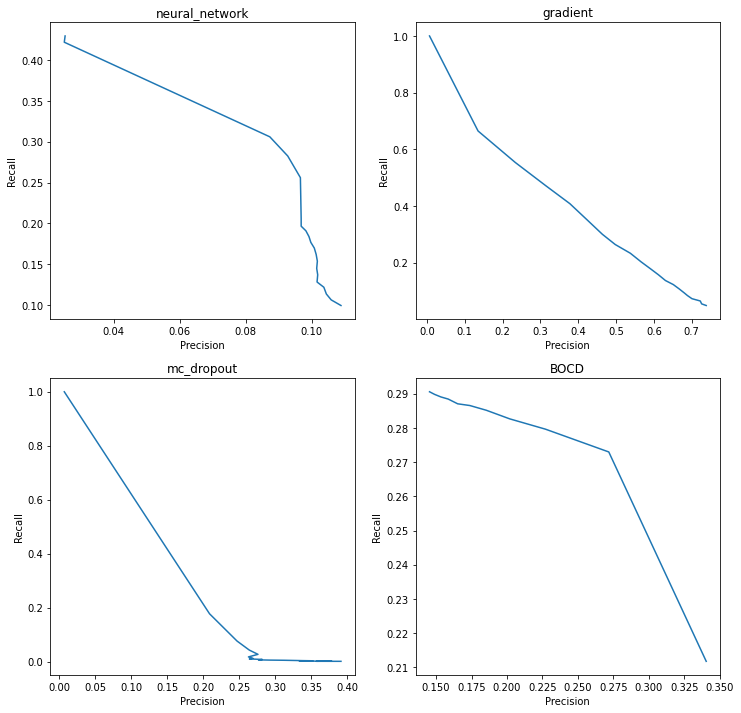

In [37]:
fig, ax = plt.subplots(2,2,figsize=[12,12])

for (row,col), df, name in zip(itertools.product([0,1],[0,1]),[df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    ax[row,col].plot(df['Precision'], df['Recall'])
    ax[row,col].set_xlabel('Precision')
    ax[row,col].set_ylabel('Recall')
    ax[row,col].set_title(name)
plt.show()

# load the model and evaluate with test data on the chosen hyperparameters

In [38]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_geo')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_geo')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_B_exp_id_40_data_id_1_geo/') 
dataset_type='test'

In [39]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=False
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
results, test_dataset,_,_=inference.main(config, params)
results.t_out.coord_main=results.t_out.coord_main.mean(0)

NameError: name 'test' is not defined

# Summary Table with test data

compute BOCD

In [ ]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
test_tensor = torch.tensor(y_pred).float()
batch_size_cpd = test_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
posterior, _, predictive, e_mean = model_cpd.run_recursive(test_tensor, 'cpu')

In [ ]:
df_test=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
trueCps=test_dataset.data['cps']
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), \
             torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(),\
             model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, trueCps, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_test=df_test.append(prMetrics, ignore_index=True)
df_test